In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-0luxmsqf
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-0luxmsqf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-4jugwzn4/pydoe_b214e63a40c1459cba8f72d6e2357828
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-4jugwzn4/pydoe_b214e63a40c1459cba8f72d6e2357828
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 316 kB 9.0 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145057 sha256=aa8e735a00182dd78cc5610d3b4dde3f9e94b68975ca9ee485b51dd24303bccd
  Stored in directory: /tmp/pip-ephem-wheel-cache-b

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from pyDOE import lhs

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F21

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

n_samples = 30000

max_cma_iter = 20

obj_func = F21(1)

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30):
  plt.suptitle("BO history", fontsize=8)
  plot(samples, values, ax=plt.gca(), outline=False) # plot surface
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=plt.gca(), marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      plt.scatter(x, y, color="magenta", s=marker_size)
      plt.annotate(str(i), h)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=plt.gca(), marker='s', marker_size=marker_size)

In [ ]:
def make_optimizer(obj_func, doe):
    space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_regret(doe, n=3):
  regrets = []
  best_bo, worst_bo = None, None
  for seed in range(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return np.concatenate(regrets).mean(), best_bo, worst_bo

def compute_precision(doe, n_tests=3, n_test_points=5):
  precisions = []
  history = []
  for seed in range(n_tests):
    points = lhs(dim, n_test_points) * 10 - 5
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    history.append({'bo': bo, 'xopt': xopt, 'yopt': yopt, 'precision': precision})
  return np.mean(precisions), history
 
def fitness_function(obj_func, doe_size, n_tests=3, n_test_points=5):
    def func(X):
        X = X.clip(lb, ub, out=X)
        doe = np.split(X, doe_size)
        regret, _ = compute_precision(doe, n_tests, n_test_points)
        return regret
    return func

## Experiments

In [ ]:
def cma_es_experiment(obj_function, doe_size, n_test=10, n_test_points=1000, individual0=None, sigma0 = ub / 3):
  if individual0 is None: 
    individual0 = np.zeros(doe_size * dim) # initial individual
  
  # regret function with fixed random
  regret_func = fitness_function(obj_function, doe_size, n_tests=n_test, n_test_points=n_test_points)
  # run cma-es 
  doe_flattened, es = cma.fmin2(regret_func, individual0, sigma0, {'maxiter': max_cma_iter})
  
  # split a vector into set of points
  doe = np.split(doe_flattened, doe_size)

  return doe, es

## DoE of size 6

In [ ]:
doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)

In [ ]:
individual0 = np.concatenate(lhs(2, doe_size) * 10 - 5)
individual0

array([ 4.80178775, -4.27884261, -3.44189721,  4.90776375, -2.33845672,
       -0.01371962,  0.63380802,  2.61304621,  2.77912012,  0.05780422,
       -0.69357446, -2.55865906])

### sigma = 3.5

In [ ]:
doe35, es35 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=3.5, n_test=3, n_test_points=1000)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=383296, Tue Nov  1 18:33:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.033273790973517e+03 1.0e+00 3.23e+00  3e+00  3e+00 6:20.2
    2     22 3.036693246440399e+03 1.1e+00 2.85e+00  3e+00  3e+00 12:24.9
    3     33 3.019717362492177e+03 1.2e+00 2.51e+00  2e+00  3e+00 18:44.1
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
    4     44 3.020434290465848e+03 1.2e+00 2.24e+00  2e+00  2e+00 24:56.6
    5     55 3.031860881347632e+03 1.2e+00 2.11e+00  2e+00  2e+00 31:01.8
    6     66 3.030762141943538e+03 1.3e+00 1.91e+00  2e+00  2e+00 37:13.0
    7     77 3.006856569463546e+03 1.3e+00 1.80e+00  2e+00  2e+00 43:13.5
    8     88 3.022353142541471e+03 1.3e+00 1.77e+00  2e+00  2e+00 49:18.6
    9     99 3.020152746071408e+03 1.4e+00 1.94e+00  2e+00  2e+00 55:09.8
   10    110 3.009275715568268

#### CMA-ES generated

In [ ]:
regret, best_bo, worst_bo = compute_regret(doe35, n=30)

In [ ]:
regret

0.7487188123960681

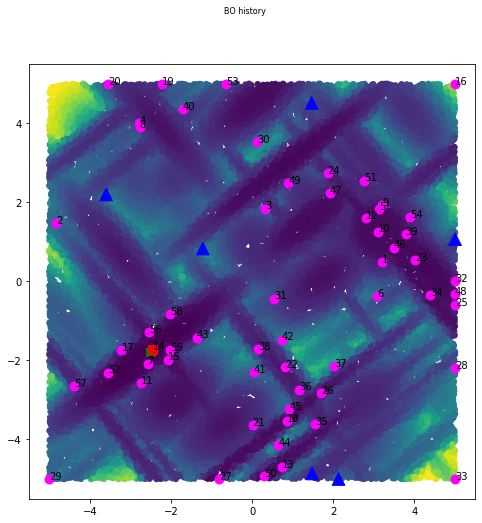

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe35), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

#### DoE used to initialize CMA-ES

In [ ]:
doe_lhs = np.split(individual0, doe_size)
lhs_regret, lhs_best_bo, lhs_worst_bo = compute_regret(doe_lhs, n=30)

In [ ]:
lhs_regret

0.6001922758002352

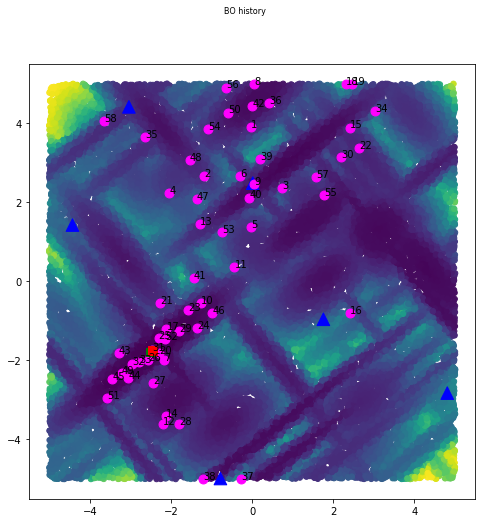

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

lhs_bo, lhs_xopt, _, lhs_best_regret = lhs_best_bo

result = {"initial_points": np.array(doe_lhs), "found_x": lhs_xopt}
plot_ei_performance(obj_func, samples, values, lhs_bo, result, marker_size=80)

### sigma = 5 / 2


In [ ]:
doe52, es52 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/2, n_test=3, n_test_points=1000)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=495619, Wed Nov  2 09:37:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.016397272707325e+03 1.0e+00 2.40e+00  2e+00  2e+00 6:33.3
    2     22 3.047261731993398e+03 1.2e+00 2.51e+00  2e+00  3e+00 12:38.8
    3     33 3.045682369961019e+03 1.3e+00 2.35e+00  2e+00  3e+00 18:37.5
    4     44 3.014081339464333e+03 1.4e+00 2.23e+00  2e+00  2e+00 24:44.9
    5     55 3.022709501740059e+03 1.4e+00 2.07e+00  2e+00  2e+00 30:53.8
    6     66 3.024703008239419e+03 1.4e+00 2.03e+00  2e+00  2e+00 36:52.2
    7     77 3.020712643005064e+03 1.5e+00 2.09e+00  2e+00  2e+00 42:49.4
    8     88 3.022253120057563e+03 1.5e+00 2.21e+00  2e+00  2e+00 49:07.5
    9     99 3.031261908887211e+03 1.6e+00 2.17e+00  2e+00  2e+00 55:31.4
   10    110 3.026758333391366e+03 1.6e+00 2.10e+00  2e+00  2e+00 61:37.4
   11    121 3.025042271740688e+03 1.6e+00 1.97e+00  2e+00  2e+00 68:00.5
   12    132 3.04298626

#### CMA-ES generated

In [21]:
regret, best_bo, worst_bo = compute_regret(doe52, n=30)

In [ ]:
regret

0.03378854924672083

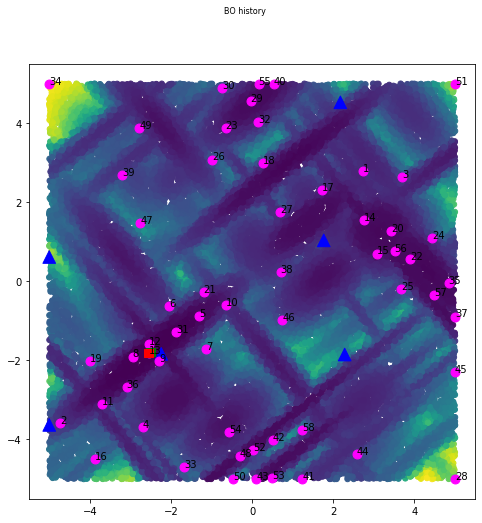

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe52), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [ ]:
best_regret

array([9.21142387e-07])

In [18]:
doe52

[array([2.1734288 , 4.52800488]),
 array([-2.23995157, -1.83375411]),
 array([-5.        ,  0.61610481]),
 array([-5.        , -3.63122171]),
 array([ 2.28007497, -1.8513258 ]),
 array([1.76429073, 1.03689174])]

In [ ]:
obj_func._getxopt()

array([-2.51487651, -1.78747656])

### sigma = 5 / 3

In [ ]:
doe53, es53 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/3, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=476874, Wed Nov  2 11:49:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.039579040496828e+03 1.0e+00 1.57e+00  2e+00  2e+00 6:47.9
    2     22 3.032931160378109e+03 1.1e+00 1.55e+00  1e+00  2e+00 13:11.5
    3     33 3.027671466183621e+03 1.1e+00 1.48e+00  1e+00  2e+00 19:15.6
    4     44 3.008278228186613e+03 1.2e+00 1.47e+00  1e+00  2e+00 25:38.5
    5     55 3.021591893928693e+03 1.3e+00 1.45e+00  1e+00  2e+00 31:56.4
    6     66 3.004964350006646e+03 1.3e+00 1.45e+00  1e+00  1e+00 38:10.8
    7     77 3.007309002199792e+03 1.4e+00 1.41e+00  1e+00  1e+00 44:20.2
    8     88 3.029841604581638e+03 1.4e+00 1.37e+00  1e+00  1e+00 50:38.4
    9     99 3.015062293398799e+03 1.5e+00 1.39e+00  1e+00  1e+00 57:15.5
   10    110 3.026583146301941e+03 1.5e+00 1.46e+00  1e+00  2e+00 63:17.0
   11    121 3.037148314321434e+03 1.6e+00 1.36e+00  1e+00  1e+00 69:25.2
   12    132 3.02236870

#### CMA-ES generated

In [ ]:
regret, best_bo, worst_bo = compute_regret(doe53, n=30)

In [17]:
regret

0.7834479441727161

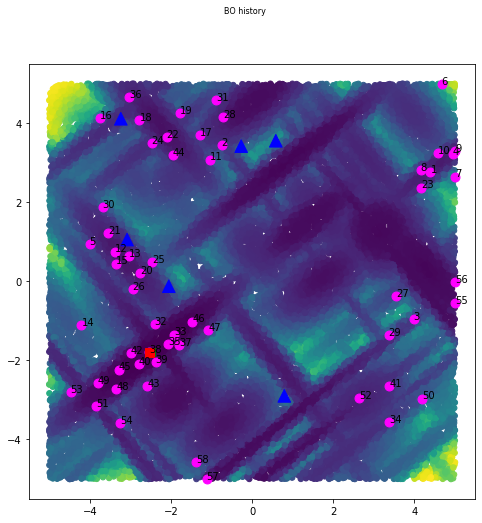

In [19]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe53), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [20]:
doe53

[array([ 0.79198408, -2.89685979]),
 array([-3.08159578,  1.05699254]),
 array([-3.23608681,  4.11326757]),
 array([0.5832361 , 3.55652566]),
 array([-0.27012109,  3.42067018]),
 array([-2.05380877, -0.12252322])]